Name: Mohammad Javad Hezareh

Student Number: 98101074


In [2]:
#dependencies
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [112]:
#load the input image
def load_img(image_name):
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    img = np.asarray(img, dtype="int32")
    img_pixels = np.reshape(img, (-1, img.shape[2]))
    return img.shape[0], img.shape[1], img_pixels

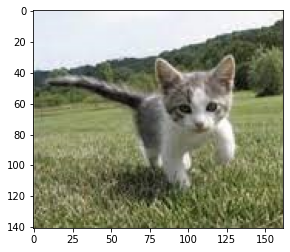

In [119]:
#write the name of your image here
image_name = 'cat.jpg'
x_pixels, y_pixels, img = load_img(image_name)

In [6]:
#determine number of desired classes here:
number_of_classes = 3

In [7]:
#Color each segment of your image. Add your desired colors in RGB format here, as an example:
#here number of desired classes for image segmentation is 3
colors = [
        (255, 0, 0),    # red
        (0, 255, 0),    # green
        (0, 0, 255),    # blue
        # ...
    ]

In [101]:
#for better results, do the initializations with Kmeans 
def get_random(k, d):
    values = list(range(256))
    result = []
    for _ in range(k):
        result.append(np.random.choice(values, d, replace=True))
        
    return np.array(result)


def assign(centers, data):
    z = []
    for x in data:
        distance = centers - x
        norms = np.linalg.norm(distance, axis=1)
        z.append(np.argmin(norms))
    
    return z
        

def update_centers(k, assignment, data):
    clusters = [[] for _ in range(k)]
    
    for i in range(data.shape[0]):
        clusters[assignment[i]].append(list(data[i]))
        
    centers = []
    for c in clusters:
        if len(c) == 0:
            centers.append(np.full(data.shape[1], 0))
            continue
        centers.append(np.average(c, axis=0))
        
    return np.array(centers)
    

def get_cov(k, assignment, centers, datas):
    clusters = [[] for _ in range(k)]
    
    for i in range(datas.shape[0]):
        clusters[assignment[i]].append(list(datas[i]))
        
    covs = []
    for i in range(k):
        points = np.asarray(clusters[i])
        points = points - centers[i]
        
        covs.append(np.cov(points.T))
    
    return covs


def calculate_cost(assignment, centers, datas):
    n = datas.shape[0]
    cost = 0
    
    for i in range(n):
        distance = datas[i] - centers[assignment[i]]
        cost += np.linalg.norm(distance)**2
        
    return cost

        
    
def kmeans(number_of_classes, img_pixels, max_iter=1000):
    centers = get_random(number_of_classes, img_pixels.shape[1])
    assignment = [0 for _ in range(img_pixels.shape[0])]
    
    for i in range(max_iter):
        assignment = assign(centers, img_pixels)
        new_centers = update_centers(number_of_classes, assignment, img_pixels)
        
        n = np.count_nonzero(new_centers - centers)
        if n == 0:
            break
            
        centers = new_centers
        
    initial_mus = centers
    initial_priors = np.unique(assignment, return_counts=True)[1]/len(assignment)
    initial_covs = get_cov(number_of_classes, assignment, centers, img_pixels)
    cost = calculate_cost(assignment, centers, img_pixels)
    
    return initial_mus, initial_priors, initial_covs, cost

In [94]:
#for better results, observe the image histogram
def get_img_histogram(image_pixels):

    # I will use k-means to find best initial parameters!
    
    return number_of_classes, initial_mus, initial_priors, initial_covs

In [115]:
class GMM:

    def __init__(self, number_of_classes, initial_mu_s, initial_sigma_s, initial_priors):
        self.k = number_of_classes
        self.mu_s = np.asarray(initial_mu_s)
        self.sigma_s = np.asarray(initial_sigma_s)
        self.priors = np.asarray(initial_priors)


    def __normal(self, x, mu, sigma):
        d = sigma.shape[0]
        power = ((x-mu) @ np.linalg.inv(sigma) @ (x-mu).T) * (-0.5)
        return np.exp(power) * (1/np.sqrt(np.linalg.det(sigma))) * (1/(2*np.pi)**(-d/2))


    def __get_belif(self, x, j):
        p = lambda i: self.priors[i] * self.__normal(x, self.mu_s[i], self.sigma_s[i])
        total = 0
        for i in range(self.k):
            total += p(i)
        
        return p(j)/total


    # Write E step here
    def inference(self, datas):
        n = datas.shape[0]
        d = datas.shape[1]
        beliefs = [[] for _ in range(n)]
        
        for i in range(n):
            for j in range(self.k):
                beliefs[i].append(self.__get_belif(datas[i], j))
                
        return np.asarray(beliefs)
        

    # Write M step here
    def update(self, datas, beliefs):
        # update mu_s
        self.mu_s = np.divide((beliefs.T @ datas), beliefs.sum(axis=0).reshape((1,-1)).T)
        
        # update sigma_s
        for i in range(self.k):
            self.sigma_s[i] = np.cov((datas-self.mu_s[i]).T, ddof=0, aweights=beliefs[:,i])
        
        # update priors
        self.priors = beliefs.sum(axis=0)/datas.shape[0]
    
    
    # return the number of cluster which x is assigned to
    def assign(self, x):
        probs = [self.priors[k]*self.__normal(x, self.mu_s[k], self.sigma_s[k]) for k in range(self.k)]
        return np.argmax(probs)

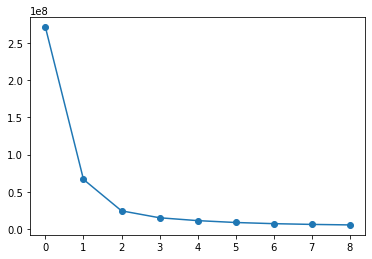

In [102]:
#write your main function here
#use of kmeans or histogram of the image for better initialization is optinal
#call the GMM functions here
max_num_of_clusters = 10

costs = []
for k in range(1, max_num_of_clusters):
    costs.append(kmeans(k, img)[3])

plt.plot(costs, marker='o');

In [123]:
# as we can see from above plot, k=2 is the best number of cluster for this problem
best_k = 3
initial_mus, initial_priors, initial_sigmas= kmeans(best_k, img)[0:3]

In [124]:
# calling E and M step of GMM till convergence
gmm = GMM(best_k, initial_mus, initial_sigmas, initial_priors)

beliefs = gmm.inference(img)

for i in range(10):
    gmm.update(img, beliefs)
    new_beliefs = gmm.inference(img)
    
    n = np.count_nonzero(beliefs-new_beliefs)
    if n == 0:
        print('hello')
        break
    beliefs = new_beliefs

In [141]:
#show and save your results
#let the final image variable be clustered_img
def save_img(clustered_img):
    plt.imshow(clustered_img)
    final_img = cv2.cvtColor(clustered_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite("result.jpg", final_img)
    
clustered_img = []
for x in img:
    k = gmm.assign(x)
    clustered_img.append(list(colors[k]))

clustered_img = np.asarray(clustered_img, dtype='float32')
clustered_img = np.reshape(clustered_img, (x_pixels, y_pixels, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


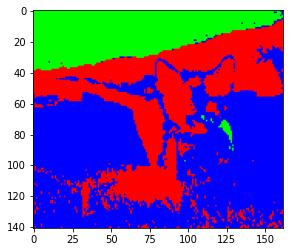

In [144]:
save_img(clustered_img)